<center><font size=5>ECE720X50 - Mini Project 2 - Q2</font></center>
<center><b> Group Member: Zhaoyi Wang, Jiyuan Zhao and Yafei Sun </b></center>
<center> Group Contect Info: zhaoyi5@ualberta.ca </center>

This notebook provides the skeleton for Question 2. Just as with Question 1, you do not need to use this notebook for the assignment, it is only to provide guidance.

Make the necessary imports to complete this question. You do not need to use these specific imports and may add or remove as you deem necessary. 

In [1]:
import os, tensorflow
print(tensorflow.config.list_physical_devices('GPU'))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11849315013635487021
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4975187744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12642606511018012699
physical_device_desc: "device: 0, name: GeForce GTX 1660 SUPER, pci bus id: 0000:0a:00.0, compute capability: 7.5"
]


In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's start with loading the training dataset.

In [5]:
data = pd.read_csv('/CodeRepository/Conda-Project/ECE720X50/Database/Project 2/weather_training.csv', parse_dates=['Date'])
data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [6]:
data.shape

(3550, 2)

The dataset consists of daily minimum temperatures from the beginning of 1981 to the middle of 1990.

Convert the data to a numpy matrix and extract the temperatures.

In [8]:
temperature = data.loc[:,'Temp']

In [9]:
temperature = temperature/max(temperature)

In [10]:
type(temperature)

pandas.core.series.Series

# Data Pre-processing

Just as in Question 1, it's a good idea to perform exploratory data analysis on the training data. In particular, a line plot charting the temperature as a function of time will be useful.

## Basic Data Exploration

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3550 entries, 0 to 3549
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3550 non-null   datetime64[ns]
 1   Temp    3550 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 55.6 KB


In [12]:
data.describe()

,Temp
count,3550.000000
mean,11.139634
std,4.090230
min,0.000000
25%,8.200000
50%,11.000000
75%,13.900000
max,26.300000


## Handle Missing/NA Value

In [13]:
data.isna().sum()

Date    0
Temp    0
dtype: int64

In [14]:
data.isnull().sum()

Date    0
Temp    0
dtype: int64

## Handle Duplicate Records

In [15]:
data.duplicated().sum()

0

## Plot Trend

Text(0.5, 1.0, 'Trend of Temperature')

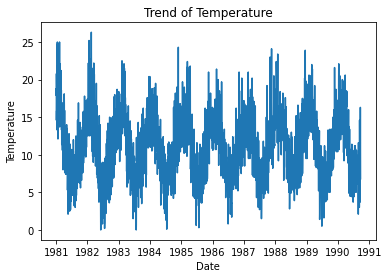

In [16]:
plt.plot(data.iloc[:,0],data.iloc[:,1])
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Trend of Temperature')

Based on the results of your exploratory data analysis, apply some preprocessing to the training data or justify in a comment why preprocessing is not necessary.

* Based on the EDA, there is no need to perform data preprocessing. This is becasue there are no missing values, na values or duplicate records.

## Prepare Training Samples

One of the key questions you will have to resolve is how to generate training samples for the neural network. Because the data is temporal, using 10-fold cross-validation at this step is not appropriate since inputs have to precede outputs. On the other hand, splitting the training data by extracting the last 100 days for validation will not capture the diversity of the decade. The correct solution will generate many samples across that span the entire decade. This will allow the network to learn and generalize patterns across seasons.

In [17]:
# Use Time-Slide-Window method to generate the samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    
    X = list()
    y = list()
    
    for i in range(len(sequence)):
        
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    X = X.reshape(X.shape[0],X.shape[1],1)
    
    y = np.array(y)
        
    return X, y

In [18]:
X, y = split_sequence(temperature,600,100)

In [19]:
X.shape

(2851, 600, 1)

In [20]:
y.shape

(2851, 100)

# Forecasting the Temperature

In [23]:
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import layers, wrappers

import tensorflow as tf

In [24]:
np.random.seed(123)
tf.random.set_seed(123)

## Build the Model

Once you've obtained the training samples, you can build the neural network. It's important that you build it such that its architecture is consistent with how training samples were generated. As in Question 1, you can use the Sequential API, this time with LSTM and Dense layers. Explore various hyperparameters and select the ones which produce the best results.

Once the model has been built, compile it with parameters suitable for time series forecasting.

In [28]:
def build_model(n_hidden, n_neurons):
    
    model = Sequential()
    
    model.add(LSTM(n_neurons,activation='relu',input_shape=(600,1)))
    
    for layer in range(n_hidden):
        model.add(LSTM(n_neurons,activation='relu',input_shape=(600,1)))
    
    model.add(Dense(100,activation='linear'))
    
    model.compile(optimizer='adam',loss='mse',loss_weights=0.0001)
    return model

## Perform Hyperparameter Exploration

In [30]:
from sklearn.model_selection import RandomizedSearchCV

In [29]:
keras_reg = wrappers.scikit_learn.KerasRegressor(build_model)

<b> Here we use 5-fold cross validation to find the best parameter </b>

In [35]:
param_distribs = {"n_hidden": [0, 1, 2, 3], "n_neurons": [4, 6, 8, 10]}

with tensorflow.device('/device:CPU:0'):
    rnd_search_cv = RandomizedSearchCV(keras_reg,
                                       param_distribs,
                                       cv=5)
    rnd_search_cv.fit(X, y, epochs=50)

Epoch 1/50
72/72 [==============================] - 8s 92ms/step - loss: 1.9235e-05
Epoch 2/50
72/72 [==============================] - 7s 92ms/step - loss: 1.5812e-05
Epoch 3/50
72/72 [==============================] - 7s 92ms/step - loss: 1.1841e-05
Epoch 4/50
72/72 [==============================] - 7s 92ms/step - loss: 8.3171e-06
Epoch 5/50
72/72 [==============================] - 7s 92ms/step - loss: 3.9941e-06
Epoch 6/50
72/72 [==============================] - 7s 93ms/step - loss: 2.4590e-06
Epoch 7/50
72/72 [==============================] - 7s 93ms/step - loss: 2.0535e-06
Epoch 8/50
72/72 [==============================] - 7s 92ms/step - loss: 1.9725e-06
Epoch 9/50
72/72 [==============================] - 7s 93ms/step - loss: 2.0002e-06
Epoch 10/50
72/72 [==============================] - 7s 92ms/step - loss: 1.9769e-06
Epoch 11/50
72/72 [==============================] - 7s 92ms/step - loss: 1.9440e-06
Epoch 12/50
72/72 [==============================] - 7s 93ms/step - loss: 

72/72 [==============================] - 7s 93ms/step - loss: 1.8577e-06
Epoch 43/50
72/72 [==============================] - 7s 93ms/step - loss: 1.8842e-06
Epoch 44/50
72/72 [==============================] - 7s 93ms/step - loss: 1.8718e-06
Epoch 45/50
72/72 [==============================] - 7s 93ms/step - loss: 1.8562e-06
Epoch 46/50
72/72 [==============================] - 7s 93ms/step - loss: 1.8460e-06
Epoch 47/50
72/72 [==============================] - 7s 93ms/step - loss: 1.8416e-06
Epoch 48/50
72/72 [==============================] - 7s 93ms/step - loss: 1.8522e-06
Epoch 49/50
72/72 [==============================] - 7s 93ms/step - loss: 1.8354e-06
Epoch 50/50
18/18 [==============================] - 1s 20ms/step - loss: 2.0220e-06
Epoch 1/50
72/72 [==============================] - 7s 92ms/step - loss: 2.0030e-05
Epoch 2/50
72/72 [==============================] - 7s 92ms/step - loss: 1.6117e-05
Epoch 3/50
72/72 [==============================] - 7s 92ms/step - loss: 1.2378

Epoch 32/50
72/72 [==============================] - 7s 94ms/step - loss: 1.9498e-06
Epoch 33/50
72/72 [==============================] - 7s 94ms/step - loss: 1.9444e-06
Epoch 34/50
72/72 [==============================] - 7s 94ms/step - loss: 1.9667e-06
Epoch 35/50
72/72 [==============================] - 7s 94ms/step - loss: 1.9173e-06
Epoch 36/50
72/72 [==============================] - 7s 94ms/step - loss: 1.9182e-06
Epoch 37/50
72/72 [==============================] - 7s 94ms/step - loss: 1.9345e-06
Epoch 38/50
72/72 [==============================] - 7s 94ms/step - loss: 1.9437e-06
Epoch 39/50
72/72 [==============================] - 7s 94ms/step - loss: 1.9223e-06: 1s -
Epoch 40/50
72/72 [==============================] - 7s 94ms/step - loss: 1.9104e-06: 0s - loss: 1.9100e-
Epoch 41/50
72/72 [==============================] - 7s 93ms/step - loss: 1.8957e-06
Epoch 42/50
72/72 [==============================] - 7s 94ms/step - loss: 1.9311e-06
Epoch 43/50
72/72 [===================

Epoch 1/50
90/90 [==============================] - 9s 92ms/step - loss: 1.9549e-05
Epoch 2/50
90/90 [==============================] - 8s 92ms/step - loss: 1.4438e-05
Epoch 3/50
90/90 [==============================] - 8s 92ms/step - loss: 9.0230e-06
Epoch 4/50
90/90 [==============================] - 8s 92ms/step - loss: 3.8918e-06
Epoch 5/50
90/90 [==============================] - 8s 92ms/step - loss: 2.2266e-06: 1s - lo
Epoch 6/50
90/90 [==============================] - 8s 92ms/step - loss: 2.0185e-06
Epoch 7/50
90/90 [==============================] - 8s 92ms/step - loss: 1.9724e-06
Epoch 8/50
90/90 [==============================] - 8s 93ms/step - loss: 1.9890e-06
Epoch 9/50
90/90 [==============================] - 8s 93ms/step - loss: 1.9738e-06
Epoch 10/50
90/90 [==============================] - 8s 92ms/step - loss: 1.9875e-06
Epoch 11/50
90/90 [==============================] - 8s 92ms/step - loss: 1.9914e-06
Epoch 12/50
90/90 [==============================] - 8s 92ms/step

In [36]:
result_regression = {
    'best parameter:':rnd_search_cv.best_params_,
    'cross-validation score:':-rnd_search_cv.score(X, y)
}

result_regression

90/90 [==============================] - 43s 481ms/step - loss: 1.8456e-06


{'best parameter:': {'n_neurons': 6, 'n_hidden': 0},
 'cross-validation score:': 1.8455626786817447e-06}

Here, the RandomSearchCV tell us:
* n_neurons = 6
* n_hidden = 0

## Use the Best Paras to Train 

Once the model has been compiled, it's ready to train and evaluate. If the samples generation was done correctly, 10-fold cross-validation may be performed at this stage to prevent overfitting of the model.

In [37]:
model = Sequential([
    LSTM(6, activation='relu', input_shape=(600, 1)),
    Dense(100, activation='linear')
])

In [38]:
model.compile(optimizer='adam',loss='mse',loss_weights=0.00001)

In [39]:
# 10-fold cross validation for training
kf = KFold(n_splits=10, random_state=10)
cv_scores = []

with tensorflow.device('/device:CPU:0'):
    
    for train, validate in kf.split(X, y):

        history = model.fit(X[train],y[train],epochs=50)
        scores = model.evaluate(X[validate],y[validate])

        cv_scores.append(scores)

Epoch 1/50
81/81 [==============================] - 19s 216ms/step - loss: 2.0152e-06
Epoch 2/50
81/81 [==============================] - 18s 217ms/step - loss: 1.9066e-06
Epoch 3/50
81/81 [==============================] - 17s 212ms/step - loss: 1.7686e-06
Epoch 4/50
81/81 [==============================] - 18s 218ms/step - loss: 1.6047e-06
Epoch 5/50
81/81 [==============================] - 17s 210ms/step - loss: 1.4095e-06
Epoch 6/50
81/81 [==============================] - 17s 210ms/step - loss: 1.2909e-06
Epoch 7/50
81/81 [==============================] - 17s 211ms/step - loss: 1.1447e-06
Epoch 8/50
81/81 [==============================] - 17s 210ms/step - loss: 1.0345e-06
Epoch 9/50
81/81 [==============================] - 17s 209ms/step - loss: 9.0572e-07
Epoch 10/50
81/81 [==============================] - 17s 210ms/step - loss: 8.0464e-07
Epoch 11/50
81/81 [==============================] - 17s 210ms/step - loss: 7.2717e-07
Epoch 12/50
81/81 [==============================] -

81/81 [==============================] - 17s 209ms/step - loss: 2.0033e-07
Epoch 37/50
81/81 [==============================] - 17s 210ms/step - loss: 1.9997e-07
Epoch 38/50
81/81 [==============================] - 17s 209ms/step - loss: 1.9961e-07
Epoch 39/50
81/81 [==============================] - 17s 208ms/step - loss: 1.9924e-07
Epoch 40/50
81/81 [==============================] - 17s 209ms/step - loss: 1.9890e-07
Epoch 41/50
81/81 [==============================] - 17s 210ms/step - loss: 1.9851e-07
Epoch 42/50
81/81 [==============================] - 17s 210ms/step - loss: 1.9815e-07
Epoch 43/50
81/81 [==============================] - 17s 209ms/step - loss: 1.9779e-07
Epoch 44/50
81/81 [==============================] - 17s 210ms/step - loss: 1.9745e-07
Epoch 45/50
81/81 [==============================] - 17s 209ms/step - loss: 1.9709e-07
Epoch 46/50
81/81 [==============================] - 17s 210ms/step - loss: 1.9674e-07
Epoch 47/50
81/81 [==============================] - 17

81/81 [==============================] - 17s 210ms/step - loss: 1.8496e-07
Epoch 21/50
81/81 [==============================] - 17s 210ms/step - loss: 1.8497e-07
Epoch 22/50
81/81 [==============================] - 17s 210ms/step - loss: 1.8493e-07
Epoch 23/50
81/81 [==============================] - 17s 210ms/step - loss: 1.8492e-07
Epoch 24/50
81/81 [==============================] - 17s 210ms/step - loss: 1.8490e-07
Epoch 25/50
81/81 [==============================] - 17s 209ms/step - loss: 1.8489e-07
Epoch 26/50
81/81 [==============================] - 17s 211ms/step - loss: 1.8489e-07
Epoch 27/50
81/81 [==============================] - 17s 214ms/step - loss: 1.8488e-07
Epoch 28/50
81/81 [==============================] - 17s 210ms/step - loss: 1.8488e-07
Epoch 29/50
81/81 [==============================] - 17s 210ms/step - loss: 1.8487e-07
Epoch 30/50
81/81 [==============================] - 17s 210ms/step - loss: 1.8488e-07
Epoch 31/50
81/81 [==============================] - 17

In [43]:
np.average(cv_scores)

1.9659575087871417e-07

In [44]:
model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_127 (LSTM)              (None, 6)                 192       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               700       
Total params: 892
Trainable params: 892
Non-trainable params: 0
_________________________________________________________________


## Make a Prediction

Use the trained model to predict the next 100 days following the last day in the training dataset. Save your predictions as a csv file.

In [45]:
# Select the test data
test_set = temperature[-600:]
test_set = np.array(test_set)
test_set = test_set.reshape(1,600,1)

In [46]:
temp_pred_norm = model.predict(test_set)

In [47]:
temp_pred = temp_pred_norm*max(data.loc[:,'Temp'])
temp_pred

array([[ 9.594449 ,  9.704085 ,  9.721449 ,  9.692204 ,  9.742716 ,
         9.7453985,  9.72812  ,  9.734692 ,  9.766306 ,  9.775976 ,
         9.783075 ,  9.806809 ,  9.800824 ,  9.825915 ,  9.774406 ,
         9.835416 ,  9.819961 ,  9.831783 ,  9.840727 ,  9.848419 ,
         9.907646 ,  9.877968 ,  9.913311 ,  9.923782 ,  9.917163 ,
         9.898711 ,  9.937553 ,  9.938661 ,  9.949249 ,  9.971067 ,
        10.028312 , 10.037274 , 10.039008 , 10.093277 , 10.096161 ,
        10.118522 , 10.117699 , 10.1498575, 10.191892 , 10.21971  ,
        10.221822 , 10.20984  , 10.253271 , 10.270733 , 10.278484 ,
        10.302219 , 10.292899 , 10.354876 , 10.315498 , 10.3480015,
        10.375938 , 10.369566 , 10.40713  , 10.404883 , 10.431805 ,
        10.481989 , 10.510778 , 10.505605 , 10.550186 , 10.518182 ,
        10.547651 , 10.568777 , 10.59883  , 10.63332  , 10.669031 ,
        10.700262 , 10.699917 , 10.738196 , 10.761619 , 10.743741 ,
        10.7811365, 10.7985115, 10.841043 , 10.8

In [48]:
np.average(temp_pred)

10.435203

In [49]:
temp_pred.shape

(1, 100)

## Save Results to File

In [50]:
temp_pred = pd.Series(temp_pred[0])
temp_pred

0      9.594449
1      9.704085
2      9.721449
3      9.692204
4      9.742716
        ...    
95    11.359118
96    11.419610
97    11.442555
98    11.440912
99    11.481438
Length: 100, dtype: float32

In [51]:
temp_pred.to_csv('Task2-PredictionTemp-Result.csv',header=False)

<b> Compare the result with 1988 and 1989 </b>

In [62]:
Sept22_index = data[data.Date=='1989-09-22'].index
Sept22_index_2 = data[data.Date=='1988-09-22'].index

In [63]:
print(Sept22_index)
print(Sept22_index_2)

Int64Index([3184], dtype='int64')
Int64Index([2820], dtype='int64')


In [64]:
data_1989 = data[3184:3284]
data_1989 = data_1989.loc[:,'Temp']

data_1988 = data[2820:2920]
data_1988 = data_1988.loc[:,'Temp']

In [66]:
print(data_1989.shape)
print(data_1988.shape)

(100,)
(100,)


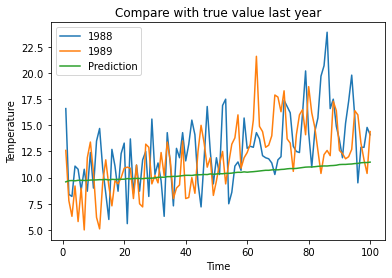

In [67]:
xlist = list(range(1,101))
plt.plot(xlist,data_1988,label='1988')
plt.plot(xlist,data_1989,label='1989')
plt.plot(xlist,temp_pred,label='Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Compare with true value last year')
plt.legend()